### Unit 08: Final Energy Demands
## Welcome to your 8-Region-Renewable-Energy System Model of Niger

#### Solution exercise 2 - Adding and changing hydrogen demands

#### 1. Import FINE and further modules to run the model 

In [13]:
import FINE as fn
import geopandas as gpd
import pandas as pd
import numpy as np
import geokit as gk
from os.path import dirname, abspath, join
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2. Set paths as input data for the model 

In [14]:
#set paths
cwd = os.getcwd()
data_dir = join(cwd, "data")

path_to_regions = join(data_dir, "regions", "region_shape_NER.shp")

path_to_pv_ts = join(data_dir, "sources", "solar_ts_NER.csv")
path_to_onshore_ts = join(data_dir, "sources", "onshore_ts_NER.csv")

path_to_pv_cap = join(data_dir, "sources", "solar_cap_NER.csv")
path_to_onshore_cap = join(data_dir, "sources", "onshore_cap_NER.csv")

path_to_el_dem = join(data_dir, "sinks", "electricity_dem_NER.xlsx")
path_to_h2_dem = join(data_dir, "sinks", "hydrogen_dem2030_NER.xlsx")

#### Hint: Where is the "data" folder? 

In [15]:
## Show path to data folder
data_dir

'c:\\Programming\\GradSchool2022\\wascal_graduate_school\\student_files\\exercises\\Unit_08_ElectricityAndHydrogenDemand\\data'

#### 2.1 Set up the regions and the commodities of the model

In [16]:
locations_shape = gpd.read_file(path_to_regions)
locations = locations_shape.GID_1.to_list() #will be ["NER.1_1", "NER.2_1", ... "NER.8_1"]

commodities = {"electricity", "hydrogen_gas"}
commodityUnitsDict = {
                "electricity": r"GW$_{el}$",
                "hydrogen_gas": r"GW$_{H_{2},LHV}$",
            }
            

#### 3 Set up the energy system model class

In [17]:
#Set up esm Model

esM = fn.EnergySystemModel(
    locations=set(locations),
    commodities=commodities,
    numberOfTimeSteps=8760, #hours per year
    commodityUnitsDict=commodityUnitsDict,
    hoursPerTimeStep=1, #time step is one hour
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0, #what is printed, just keep it
)


#### 4 Add the electricity "sources" to the model

Wind Onshore

In [18]:
# to add pv, the maximum capacity and the time series of each region must first be loaded as input data
pv_time_series=pd.read_csv(path_to_pv_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(path_to_pv_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
# add PV
esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.45, #1e9EUR/GW, 2030
        opexPerCapacity=0.017*0.45, #1e9EUR/a
        interestRate=0.08,  #1
        economicLifetime=20, #a
        ),
)


Solar PV

In [19]:
# to add wind, the maximum capacity and the time series of each region must first be loaded as input data
onshore_time_series=pd.read_csv(path_to_onshore_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
onshore_capacity_max=pd.read_csv(path_to_onshore_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
#add Wind Onshore
esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.13, #1e9EUR/GW, 2030
        opexPerCapacity=0.025*1.13, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #years
        ),
)

4.1 Add super expensive power source, so that the electricity demand also can be compensated when the sun is not shining and the wind is not blowing. If you would not add this, the model would not be solveable! 

In [20]:
# Add SuperExpensiveElectricity
esM.add(
    fn.Source(
        esM=esM, 
        name="SuperExpensiveElectricity", 
        commodity="electricity", 
        hasCapacityVariable=True,
        investPerCapacity=10e10, 
        opexPerCapacity=10e10,
        opexPerOperation=10e10, 
        interestRate=0.08, 
        economicLifetime=20, #years
        ),
)

#### 5 Add the "Conversion" class electrolyzer

In [21]:
#add Electrolyzer
esM.add(
fn.Conversion(
    esM=esM,
    name="electrolyzer",
    physicalUnit=r"GW$_{el}$",
    commodityConversionFactors={"electricity": -1, "hydrogen_gas": 0.7},
    hasCapacityVariable=True,
    investPerCapacity=0.5,
    opexPerCapacity=0.025,
    interestRate=0.08,
    economicLifetime=10,
    )
)

#### 6 Add the Demand

Electricity Demand

In [22]:
#add electricity Demands
electricity_demand_operationRateFix=pd.read_excel(path_to_el_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="electricity_demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, #GW
    ),
)

# Hint
print(f"Here you can find the electricity demands: {path_to_el_dem}") 

Here you can find the electricity demands: c:\Programming\GradSchool2022\wascal_graduate_school\student_files\exercises\Unit_08_ElectricityAndHydrogenDemand\data\sinks\electricity_dem_NER.xlsx


Hydrogen Demand

In [23]:
#add hydrogen Demands
hydrogen_demand_operationRateFix=pd.read_excel(path_to_h2_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="hydrogen_demand", 
        commodity="hydrogen_gas",
        hasCapacityVariable=False, 
        operationRateFix=hydrogen_demand_operationRateFix, #GW
    )
)

# Hint
print(f"Here you can find the hydrogen demands: {path_to_h2_dem}") 

Here you can find the hydrogen demands: c:\Programming\GradSchool2022\wascal_graduate_school\student_files\exercises\Unit_08_ElectricityAndHydrogenDemand\data\sinks\hydrogen_dem2030_NER.xlsx


#### 7 Right now you have 8760 time steps. Aggregation to 7 typical time periods with the "aggregateTemporally" method

In [24]:
# use time aggregation tool to reduce the calculation time to 7 typical time periods
esM.aggregateTemporally(numberOfTypicalPeriods=7, segmentation=True)


Clustering time series data with 7 typical periods and 24 time steps per period 
further clustered to 24 segments per period...
		(0.3588 sec)



 c:\Users\a.burdack\Anaconda3\envs\GradSchoolESM\lib\site-packages\tsam\timeseriesaggregation.py:1070: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


#### 8 Start the optimization

In [25]:
#Optimize the model:
print('Optimize')
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="",
    solver="glpk"
)
print('Optimization done!')

Optimize
Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24, number of segments per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4624 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0207 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0592 sec)

		(0.0000 sec)

Declaring objective function...
		(0.0678 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpsv6zvhnb.glpk.raw --wglp
 C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmprc0kl6_j.glpk.glp --cpxlp C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpl4icdn79.pyomo.lp
Reading problem data from 'C:\User

### Results:

In [26]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

NER.1_1  \
Component                 Property  Unit                                           
Onshore                   TAC       [1e9 Euro/a]                             0.0   
                          capacity  [GW$_{el}$]                              0.0   
                          capexCap  [1e9 Euro/a]                             0.0   
                          invest    [1e9 Euro]                               0.0   
                          operation [GW$_{el}$*h/a]                          0.0   
                                    [GW$_{el}$*h]                            0.0   
                          opexCap   [1e9 Euro/a]                             0.0   
PV                        TAC       [1e9 Euro/a]                       10.920155   
                          capacity  [GW$_{el}$]                       204.178033   
                          capexCap  [1e9 Euro/a]                        9.358193   
                          invest    [1e9 Euro]                         91.880115   
                          operation [GW$_{el}$*h/a]                    95.538513   
                                    [GW$_{el}$*h]                      95.538513   
                          opexCap   [1e9 Euro/a]                        1.561962   
SuperExpensiveElectricity TAC       [1e9 Euro/a]            8042931930819.911133   
                          capacity  [GW$_{el}$]                         0.040157   
                          capexCap  [1e9 Euro/a]                409004202.701274   
                          invest    [1e9 Euro]                  4015663552.38738   
                          operation [GW$_{el}$*h/a]                    80.385073   
                                    [GW$_{el}$*h]                      80.385073   
                          opexCap   [1e9 Euro/a]                4015663552.38738   
                          opexOp    [1e9 Euro/a]            8038507263064.822266   
electricity_demand        operation [GW$_{el}$*h/a]                   168.551627   
                                    [GW$_{el}$*h]                     168.551627   
hydrogen_demand           operation [GW$_{H_{2},LHV}$*h/a]              5.160371   
                                    [GW$_{H_{2},LHV}$*h]                5.160371   

                                                                          NER.2_1  \
Component                 Property  Unit                                            
Onshore                   TAC       [1e9 Euro/a]                              0.0   
                          capacity  [GW$_{el}$]                               0.0   
                          capexCap  [1e9 Euro/a]                              0.0   
                          invest    [1e9 Euro]                                0.0   
                          operation [GW$_{el}$*h/a]                           0.0   
                                    [GW$_{el}$*h]                             0.0   
                          opexCap   [1e9 Euro/a]                              0.0   
PV                        TAC       [1e9 Euro/a]                         1.389531   
                          capacity  [GW$_{el}$]                         25.980555   
                          capexCap  [1e9 Euro/a]                          1.19078   
                          invest    [1e9 Euro]                           11.69125   
                          operation [GW$_{el}$*h/a]                    128.683033   
                                    [GW$_{el}$*h]                      128.683033   
                          opexCap   [1e9 Euro/a]                         0.198751   
SuperExpensiveElectricity TAC       [1e9 Euro/a]            10788933298101.310547   
                          capacity  [GW$_{el}$]                          0.053902   
                          capexCap  [1e9 Euro/a]                 549007187.163479   
                          invest    [1e9 Euro]                   5390233491.32014   
                    

In [27]:
esM.getOptimizationSummary("ConversionModel", 2)

NER.1_1    NER.2_1    NER.3_1  \
Component    Property  Unit                                              
electrolyzer TAC       [1e9 Euro/a]     0.000126   0.000284    0.00081   
             capacity  [GW$_{el}$]      0.001269    0.00285   0.008138   
             capexCap  [1e9 Euro/a]     0.000095   0.000212   0.000606   
             invest    [1e9 Euro]       0.000635   0.001425   0.004069   
             operation [GW$_{el}$*h/a]  7.371959  11.711759  33.445839   
                       [GW$_{el}$*h]    7.371959  11.711759  33.445839   
             opexCap   [1e9 Euro/a]     0.000032   0.000071   0.000203   

                                          NER.4_1    NER.5_1   NER.6_1  \
Component    Property  Unit                                              
electrolyzer TAC       [1e9 Euro/a]      0.001339   0.000408  0.001304   
             capacity  [GW$_{el}$]       0.013457   0.004102  0.013105   
             capexCap  [1e9 Euro/a]      0.001003   0.000306  0.000977   
             invest    [1e9 Euro]        0.006728   0.002051  0.006552   
             operation [GW$_{el}$*h/a]  55.302314  16.855982   53.8569   
                       [GW$_{el}$*h]    55.302314  16.855982   53.8569   
             opexCap   [1e9 Euro/a]      0.000336   0.000103  0.000328   

                                          NER.7_1   NER.8_1  
Component    Property  Unit                                  
electrolyzer TAC       [1e9 Euro/a]      0.001045   0.00155  
             capacity  [GW$_{el}$]       0.010497  0.015574  
             capexCap  [1e9 Euro/a]      0.000782   0.00116  
             invest    [1e9 Euro]        0.005248  0.007787  
             operation [GW$_{el}$*h/a]  43.138551  64.00241  
                       [GW$_{el}$*h]    43.138551  64.00241  
             opexCap   [1e9 Euro/a]      0.000262  0.000389

## Plots

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

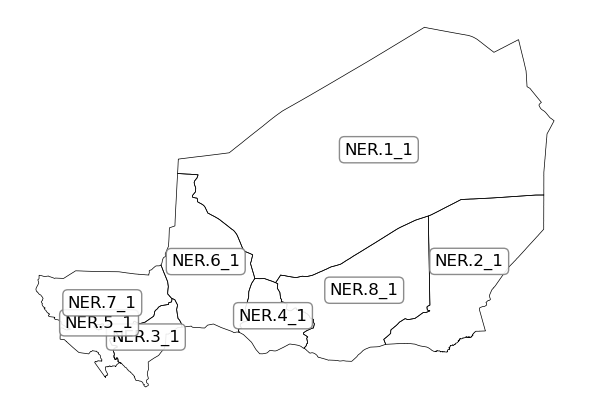

In [28]:
## Show GID_1 Regions in Niger
fn.plotLocations(path_to_regions, plotLocNames=True, indexColumn="GID_1")

#### 1 Installed electrolyzer capacity

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

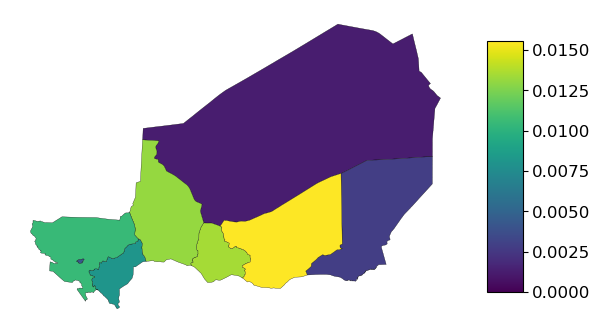

In [29]:
fn.plotLocationalColorMap(
    esM, "electrolyzer", path_to_regions, "GID_1", perArea=False
)